## Abalone Bonus Assignment
Author: Andrew Knight

In [35]:
# Setup and Imports
import pandas as pd
import numpy as np  # arrays and math functions
import matplotlib.pyplot as plt  # static plotting
import seaborn as sea
import statsmodels as sm
import statsmodels.formula.api as smf  # R-like model specification
import statsmodels.api as sm
import statsmodels.tools
import matplotlib.pyplot as plt 
from scipy import stats
from sklearn import linear_model, metrics
from statsmodels.genmod.families.family import Poisson, NegativeBinomial

In [4]:
#Read in the auto ins dataset
train = pd.read_sas('zip_abalone.sas7bdat')
test = pd.read_sas('zip_abalone_test.sas7bdat')

print('--------------- TRAIN --------------')
print(train.shape)
print('\n-------------- TEST ---------------')
print(test.shape)

--------------- TRAIN --------------
(3310, 10)

-------------- TEST ---------------
(867, 10)


### Part 1 - EDA

#### TRAIN DATA SET

In [10]:
# Now we have the training and test sets, let's take a look at the data
# ------------- TRAINING -----------------
print(train.info())
train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3310 entries, 0 to 3309
Data columns (total 10 columns):
INDEX            3310 non-null float64
TARGET_RINGS     3310 non-null float64
Sex              3310 non-null object
Length           3310 non-null float64
Diameter         3310 non-null float64
Height           3310 non-null float64
WholeWeight      3310 non-null float64
ShuckedWeight    3310 non-null float64
VisceraWeight    3310 non-null float64
ShellWeight      3310 non-null float64
dtypes: float64(9), object(1)
memory usage: 258.7+ KB
None


,INDEX,TARGET_RINGS,Length,Diameter,Height,WholeWeight,ShuckedWeight,VisceraWeight,ShellWeight
count,3310.000000,3310.000000,3310.000000,3310.000000,3310.000000,3310.000000,3310.000000,3310.000000,3310.000000
mean,2089.968882,9.109970,0.522761,0.407171,0.139014,0.825717,0.358066,0.179696,0.237974
std,1207.534917,4.530678,0.120648,0.099681,0.042363,0.492881,0.222895,0.110213,0.139573
min,2.000000,0.000000,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500
25%,1037.250000,8.000000,0.450000,0.345000,0.115000,0.436500,0.181500,0.091625,0.128250
50%,2104.000000,9.000000,0.540000,0.425000,0.140000,0.791250,0.334500,0.169000,0.230000
75%,3116.750000,11.000000,0.615000,0.480000,0.165000,1.150375,0.500250,0.251250,0.329750
max,4177.000000,29.000000,0.800000,0.630000,1.130000,2.825500,1.488000,0.760000,1.005000


In the TRAINING set we have 3310 records, 7 independent predictor variables and one numeric dependent variable. There are no null values.

INDEX                AxesSubplot(0.125,0.71587;0.168478x0.16413)
TARGET_RINGS      AxesSubplot(0.327174,0.71587;0.168478x0.16413)
Length            AxesSubplot(0.529348,0.71587;0.168478x0.16413)
Diameter          AxesSubplot(0.731522,0.71587;0.168478x0.16413)
Height              AxesSubplot(0.125,0.518913;0.168478x0.16413)
WholeWeight      AxesSubplot(0.327174,0.518913;0.168478x0.16413)
ShuckedWeight    AxesSubplot(0.529348,0.518913;0.168478x0.16413)
VisceraWeight    AxesSubplot(0.731522,0.518913;0.168478x0.16413)
ShellWeight         AxesSubplot(0.125,0.321957;0.168478x0.16413)
dtype: object

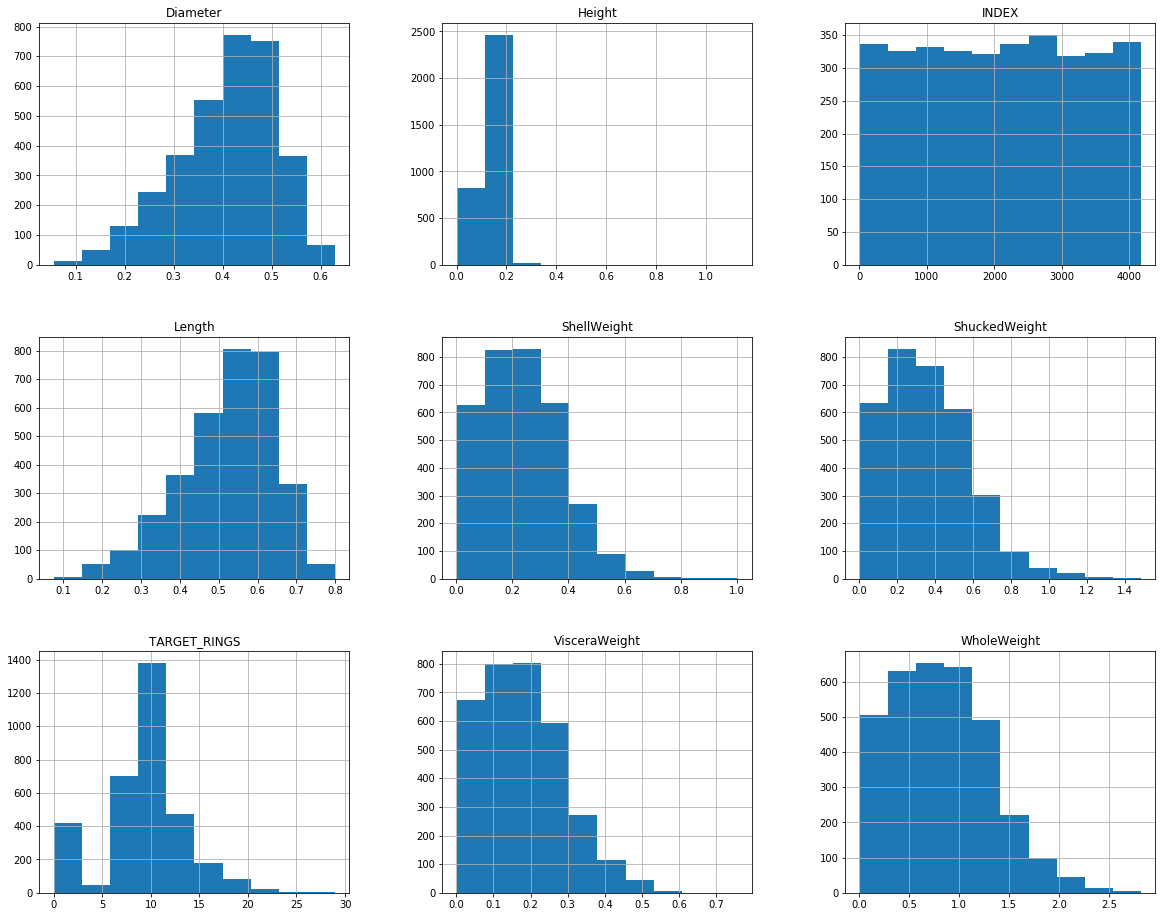

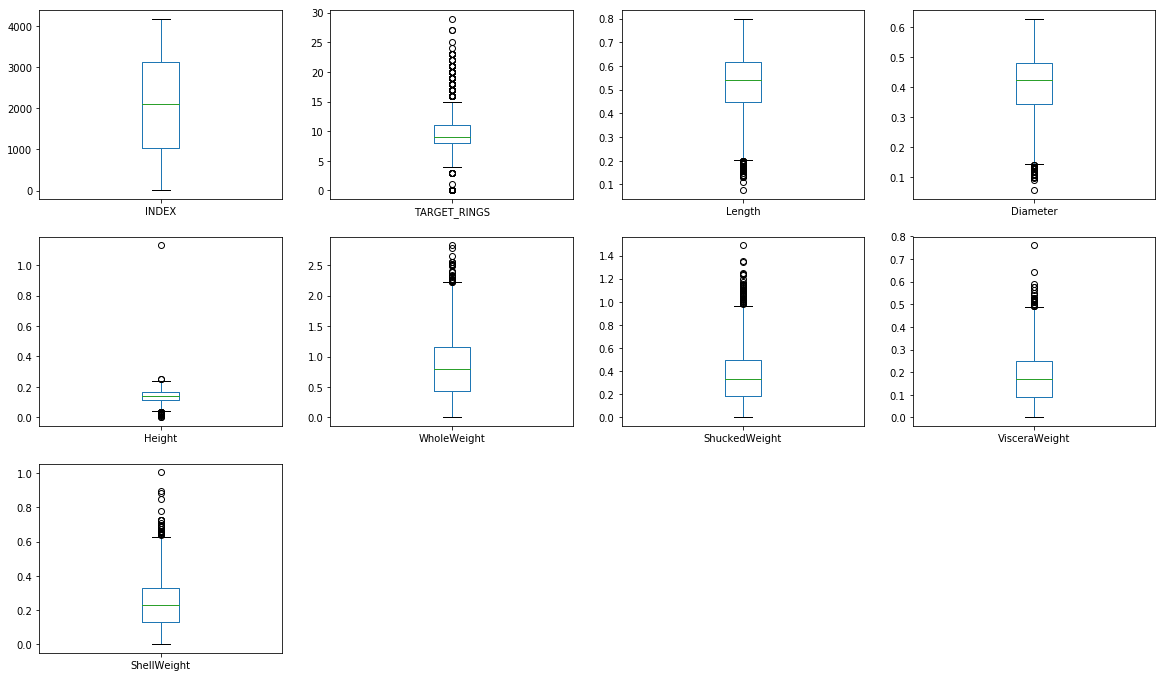

In [6]:
# Show training data plots
train.hist(figsize = (20, 16))
train.plot(kind='box', subplots=True, layout=(4,4), sharex=False, sharey=False, figsize=(20,16))

(array([ 419.,   44.,  703., 1381.,  473.,  177.,   83.,   25.,    2.,
           3.]),
 array([ 0. ,  2.9,  5.8,  8.7, 11.6, 14.5, 17.4, 20.3, 23.2, 26.1, 29. ]),
 <a list of 10 Patch objects>)

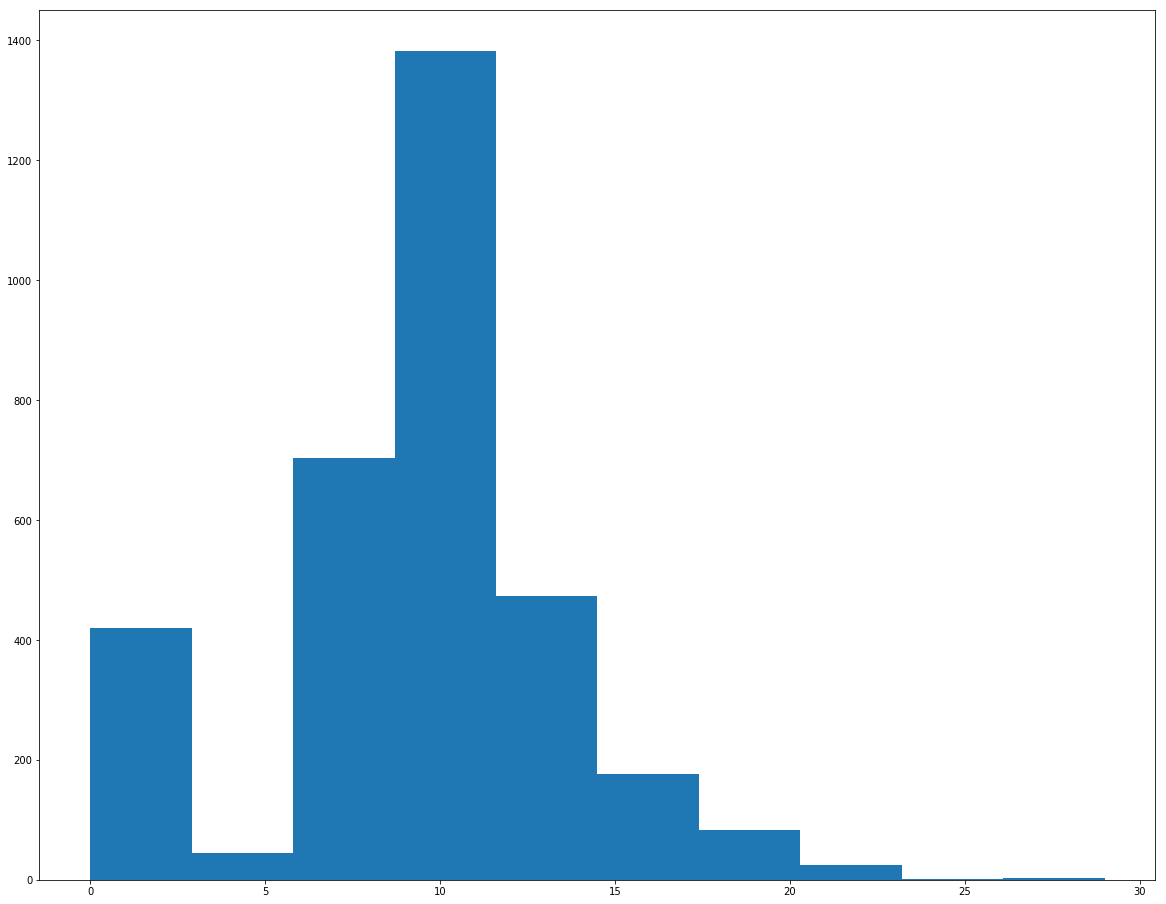

In [7]:
plt.figure(figsize = (20, 16))
plt.hist(train['TARGET_RINGS'])

The histogram of the response variable TARGET_RINGS shows a large number of zero values indicating this may be best predicted using a zero-inflated model.

#### TEST DATA SET

In [11]:
# We need to perform the same actions on the test set, let's take a look at the data
# ------------- TEST -----------------
print(test.info())
test.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 867 entries, 0 to 866
Data columns (total 10 columns):
INDEX            867 non-null float64
TARGET_RINGS     0 non-null float64
Sex              867 non-null object
Length           867 non-null float64
Diameter         867 non-null float64
Height           867 non-null float64
WholeWeight      867 non-null float64
ShuckedWeight    867 non-null float64
VisceraWeight    867 non-null float64
ShellWeight      867 non-null float64
dtypes: float64(9), object(1)
memory usage: 67.8+ KB
None


,INDEX,TARGET_RINGS,Length,Diameter,Height,WholeWeight,ShuckedWeight,VisceraWeight,ShellWeight
count,867.000000,0.0,867.000000,867.000000,867.000000,867.000000,867.000000,867.00000,867.000000
mean,2085.301038,NaN,0.528691,0.410594,0.141436,0.840291,0.364335,0.18402,0.242101
std,1200.520456,NaN,0.117899,0.097546,0.039679,0.480861,0.218426,0.10729,0.137811
min,1.000000,NaN,0.160000,0.110000,0.020000,0.018000,0.006500,0.00250,0.005000
25%,1058.500000,NaN,0.460000,0.355000,0.115000,0.466000,0.195250,0.09900,0.135750
50%,2048.000000,NaN,0.550000,0.425000,0.145000,0.824500,0.342000,0.17850,0.238000
75%,3169.500000,NaN,0.620000,0.485000,0.170000,1.168500,0.508250,0.25800,0.328000
max,4174.000000,NaN,0.815000,0.650000,0.515000,2.505000,1.245500,0.54100,0.885000


In TEST data, we have 867 observations and no response data. The goal will be to predict the resopnse TARGET_RINGS for the test data using zero-inflated model. There are no negative or null values in this set of predictors.

INDEX                AxesSubplot(0.125,0.71587;0.168478x0.16413)
TARGET_RINGS      AxesSubplot(0.327174,0.71587;0.168478x0.16413)
Length            AxesSubplot(0.529348,0.71587;0.168478x0.16413)
Diameter          AxesSubplot(0.731522,0.71587;0.168478x0.16413)
Height              AxesSubplot(0.125,0.518913;0.168478x0.16413)
WholeWeight      AxesSubplot(0.327174,0.518913;0.168478x0.16413)
ShuckedWeight    AxesSubplot(0.529348,0.518913;0.168478x0.16413)
VisceraWeight    AxesSubplot(0.731522,0.518913;0.168478x0.16413)
ShellWeight         AxesSubplot(0.125,0.321957;0.168478x0.16413)
dtype: object

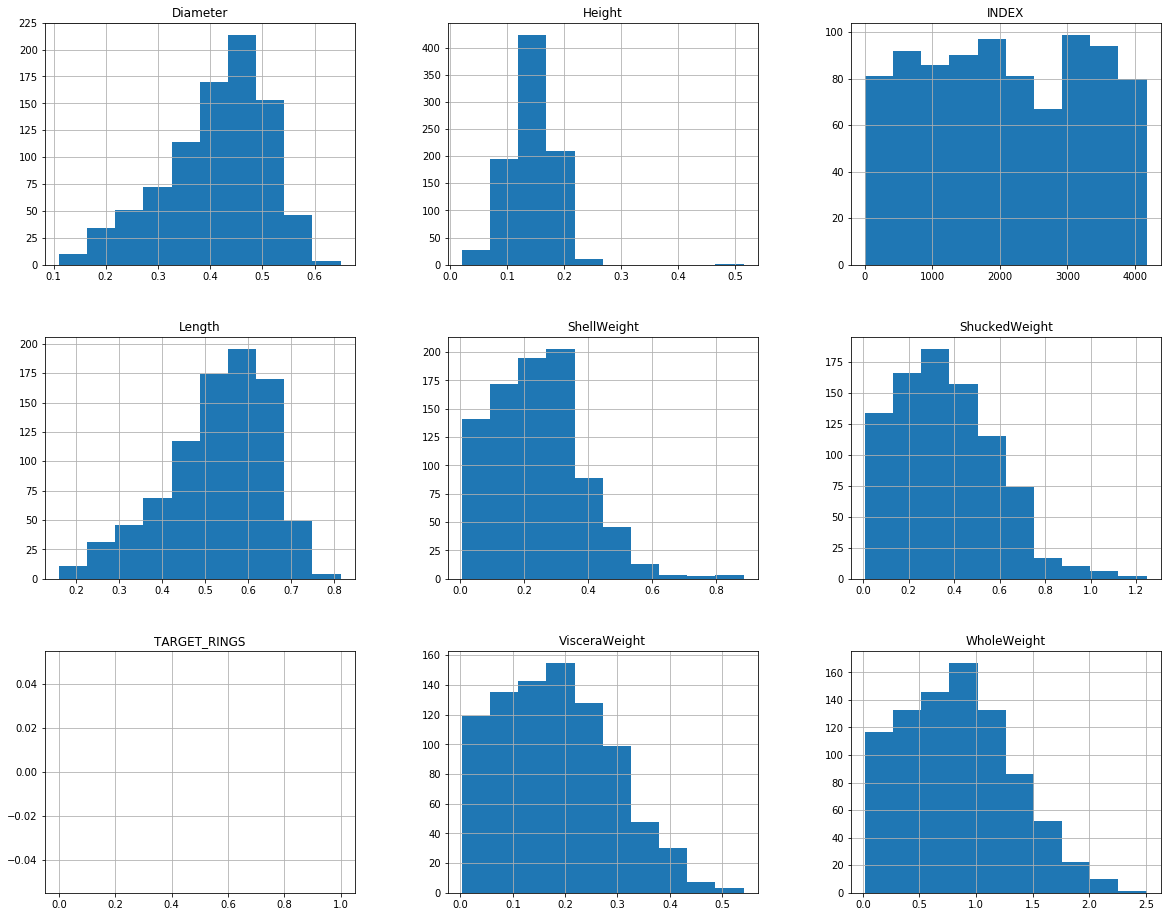

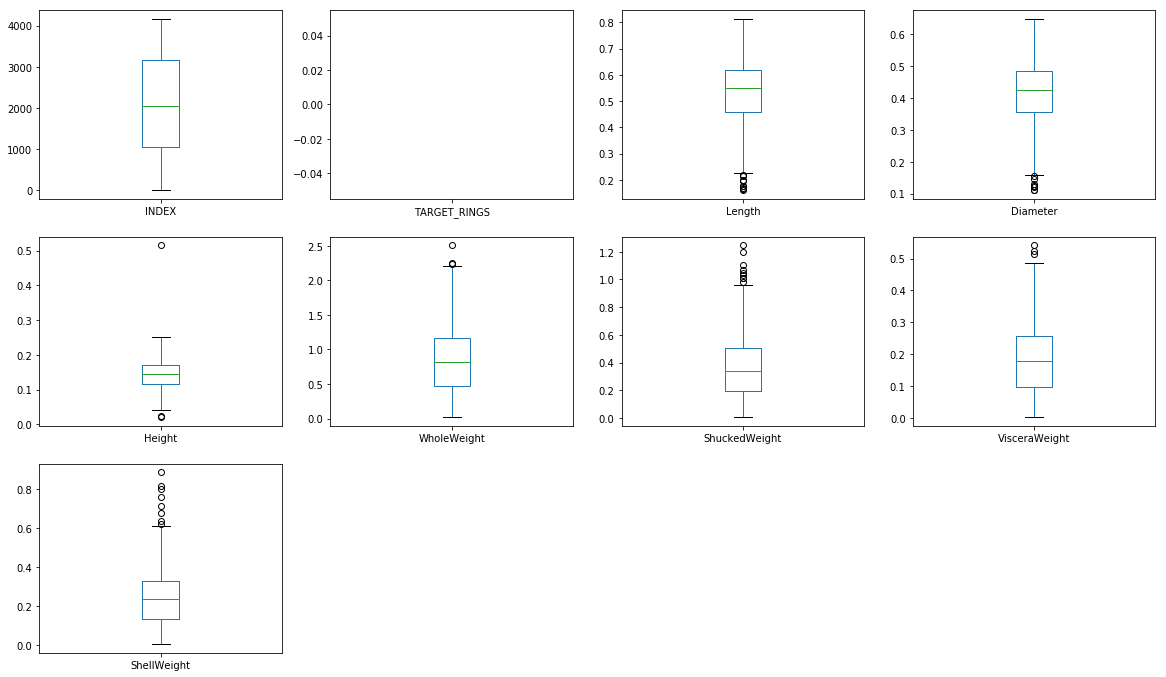

In [12]:
# Show test data plots
test.hist(figsize = (20, 16))
test.plot(kind='box', subplots=True, layout=(4,4), sharex=False, sharey=False, figsize=(20,16))

### Part 2 - Data Cleaning

In [14]:
# TRAIN
# Check the mean and variance of the TARGET_RINGS in training data:
print(np.mean(train['TARGET_RINGS']))
print(np.var(train['TARGET_RINGS']))


9.109969788519637
20.520837159208114


Note: this is overdispersed poisson

I noticed a few items that need addressed before proceeding to model building.

In [17]:
# TRAIN
# First, the min height reported in the training set shows 0 which clearly isn't correct. There are several small height values, but should not be zero.
print('There are ' + str(len(train[train['Height'] == 0])) + ' records in training with height of zero.') 
# let's changes these to the match the lower quartile as a limited min
a = np.array(train['Height'].values.tolist())
train['Height'] = np.where(a == 0, np.quantile(train['Height'], .25), a).tolist()
train['Height'].describe()


# TEST


There are 0 records in training with height of zero.


count    3310.000000
mean        0.139083
std         0.042229
min         0.010000
25%         0.115000
50%         0.140000
75%         0.165000
max         1.130000
Name: Height, dtype: float64

In [16]:
# Now lets replot the train and test sets with cleaned data
# ----- TRAIN ------
# train.hist(figsize = (20, 16))
# train.plot(kind='box', subplots=True, layout=(5,5), sharex=False, sharey=False, figsize=(20,16))

In [17]:
# ----- TEST ------
# test.hist(figsize = (20, 16))
# test.plot(kind='box', subplots=True, layout=(5,5), sharex=False, sharey=False, figsize=(20,16))

Now let's save the clearned sets as new data frames to build the models with.

In [18]:
# TRAIN
train_clean = train

# TEST
test_clean = test

### Part 3 - Build Models

Now we need to determine the parameters to use for the model. Because this is a two-step model I will not focus much on variable selection. I chose two predictor sets to try, a simple option and complex option. After checking the p-values, I removed the insignificant variables and moved forward with option 2 below. After adding a constant term for the intercept, I created the y and X parameters for model 2.

In [19]:
#First create new var to indicate zero rings 
train['TARGET_BINARY'] = np.where(train['TARGET_RINGS'] == 0, 0, 1)

In [20]:
# Model Param trials
p1 = ['Diameter', 'Height'] # model1
p2 = ['Diameter', 'Height', 'ShuckedWeight', 'WholeWeight'] # model2

# ------------------- TRAIN ------------------------
train = sm.tools.tools.add_constant(train)
y = train['TARGET_BINARY']
X = train[p2].copy()
#X["intercept"] = 1
 
# ------------------- TEST  ------------------------
test = sm.tools.tools.add_constant(test)
X_test = test[p2].copy()
#X_test["intercept"] = 1

print(X_test.head())
print(X.head())

   Diameter  Height  ShuckedWeight  WholeWeight
0     0.365   0.095         0.2245       0.5140
1     0.420   0.135         0.2565       0.6770
2     0.400   0.130         0.2580       0.6645
3     0.340   0.100         0.1880       0.4510
4     0.280   0.095         0.0955       0.2455
   Diameter  Height  ShuckedWeight  WholeWeight
0     0.265   0.090         0.0995       0.2255
1     0.365   0.125         0.2155       0.5160
2     0.255   0.080         0.0895       0.2050
3     0.300   0.095         0.1410       0.3515
4     0.415   0.150         0.2370       0.7775


### Step 1 - Logistic model to determine if abalone has at least one ring

We need to build a logistic model to separate the training data into zero and not-zero ring counts

In [21]:
logit1 = smf.Logit(y, X)
result = logit1.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.123779
         Iterations 11


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          TARGET_BINARY   No. Observations:                 3310
Model:                          Logit   Df Residuals:                     3306
Method:                           MLE   Df Model:                            3
Date:                Sat, 18 Aug 2018   Pseudo R-squ.:                  0.6736
Time:                        03:10:50   Log-Likelihood:                -409.71
converged:                       True   LL-Null:                       -1255.4
                                        LLR p-value:                     0.000
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Diameter        -43.1887      3.608    -11.969      0.000     -50.261     -36.117
Height           61.8251      8.938      6.917      0.000      44.307      79.343
ShuckedWeight   -55.5535      6.742     -8.240      0.000     -68.768     -42.339
WholeWeight      50.1373      3.996     12.548      0.000      42.306      57.968
=================================================================================

Possibly complete quasi-separation: A fraction 0.55 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

/home/knightandrew/miniconda3/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


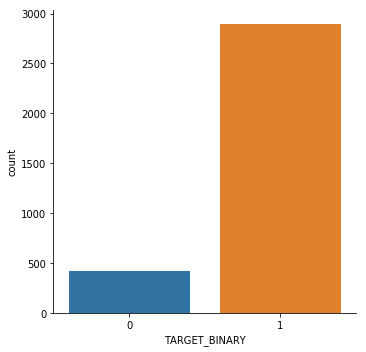

In [22]:
sea.factorplot("TARGET_BINARY", data = train, aspect=1.0, kind='count')

In [23]:
# Now predict using the model zero logit model fit above
predarray = result.predict(X)
train['y_binary_pred'] = predarray

In [24]:
#separate into two data frames from zero ring records and those with one or more rings
hasrings = pd.DataFrame(np.where(train['TARGET_BINARY'] == 1, train['y_binary_pred'], np.nan)).dropna()
norings = pd.DataFrame(np.where(train['TARGET_BINARY'] == 0, train['y_binary_pred'], np.nan)).dropna()
print(len(hasrings) + len(norings)) # just checking to make sure this equals total count of train

# now check min of hasrings and the max of no rings, use this to establish a cutoff point in y_binary_flag
print(hasrings.describe())
print(norings.describe())

# Let's just use 0.9 for now as a simple cutoff value.
cutoff_val = 0.9


3310
                 0
count  2892.000000
mean      0.954399
std       0.145446
min       0.037908
25%       0.997536
50%       0.999997
75%       1.000000
max       1.000000
                  0
count  4.180000e+02
mean   3.045117e-01
std    2.368010e-01
min    2.448832e-12
25%    1.187202e-01
50%    2.347389e-01
75%    4.231767e-01
max    9.845970e-01


In [25]:
# Now use Logit predict to create a new variable in test for the predictions
# ------------- TRAIN --------------
train['y_binary_pred'] = result.predict(X)
train['y_binary_flag'] = np.where(train['y_binary_pred'] > cutoff_val, 1, 0)

# ------------- TEST  --------------
test['y_binary_pred'] = result.predict(X_test)
test['y_binary_flag'] = np.where(test['y_binary_pred'] > cutoff_val, 1, 0)

In [26]:
#train.head(50)
test.head(10)

,const,INDEX,TARGET_RINGS,Sex,Length,Diameter,Height,WholeWeight,ShuckedWeight,VisceraWeight,ShellWeight,y_binary_pred,y_binary_flag
0,1.0,1.0,NaN,b'M',0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,0.967963,1
1,1.0,3.0,NaN,b'F',0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,0.999950,1
2,1.0,16.0,NaN,b'M',0.500,0.400,0.130,0.6645,0.2580,0.1330,0.240,0.999941,1
3,1.0,18.0,NaN,b'F',0.440,0.340,0.100,0.4510,0.1880,0.0870,0.130,0.975064,1
4,1.0,21.0,NaN,b'M',0.355,0.280,0.095,0.2455,0.0955,0.0620,0.075,0.686517,0
5,1.0,24.0,NaN,b'F',0.550,0.415,0.135,0.7635,0.3180,0.2100,0.200,0.999984,1
6,1.0,28.0,NaN,b'M',0.590,0.445,0.140,0.9310,0.3560,0.2340,0.280,1.000000,1
7,1.0,29.0,NaN,b'M',0.605,0.475,0.180,0.9365,0.3940,0.2190,0.295,1.000000,1
8,1.0,35.0,NaN,b'F',0.705,0.550,0.200,1.7095,0.6330,0.4115,0.490,1.000000,1
9,1.0,36.0,NaN,b'M',0.465,0.355,0.105,0.4795,0.2270,0.1240,0.125,0.930204,1


While this is a simplistic model for estimating zero rings in the test set, it provides a viable method to subset the test data based on 'no rings' using a consistent method from train data.

In [27]:
# Final piece is to create a reduced data set for use in the following Poisson model

# ------------- TRAIN --------------
reduced_train = train[train['y_binary_flag'] == 1]
print(reduced_train.head(10))

# ------------- TEST  --------------
reduced_test = test[test['y_binary_flag'] == 1]

#print(len(reduced_test[reduced_test['y_binary_flag'] == 0]))
#reduced_test.describe()
reduced_test.head(10)

    const  INDEX  TARGET_RINGS   Sex  Length  Diameter  Height  WholeWeight  \
1     1.0    4.0          10.0  b'M'   0.440     0.365   0.125       0.5160   
3     1.0    6.0           0.0  b'I'   0.425     0.300   0.095       0.3515   
4     1.0    7.0          20.0  b'F'   0.530     0.415   0.150       0.7775   
5     1.0    8.0          16.0  b'F'   0.545     0.425   0.125       0.7680   
6     1.0    9.0           9.0  b'M'   0.475     0.370   0.125       0.5095   
7     1.0   10.0          19.0  b'F'   0.550     0.440   0.150       0.8945   
8     1.0   11.0          14.0  b'F'   0.525     0.380   0.140       0.6065   
9     1.0   12.0          10.0  b'M'   0.430     0.350   0.110       0.4060   
10    1.0   13.0          11.0  b'M'   0.490     0.380   0.135       0.5415   
11    1.0   14.0          10.0  b'F'   0.535     0.405   0.145       0.6845   

    ShuckedWeight  VisceraWeight  ShellWeight  TARGET_BINARY  y_binary_pred  \
1          0.2155         0.1140        0.155      

,const,INDEX,TARGET_RINGS,Sex,Length,Diameter,Height,WholeWeight,ShuckedWeight,VisceraWeight,ShellWeight,y_binary_pred,y_binary_flag
0,1.0,1.0,NaN,b'M',0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,0.967963,1
1,1.0,3.0,NaN,b'F',0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,0.999950,1
2,1.0,16.0,NaN,b'M',0.500,0.400,0.130,0.6645,0.2580,0.1330,0.240,0.999941,1
3,1.0,18.0,NaN,b'F',0.440,0.340,0.100,0.4510,0.1880,0.0870,0.130,0.975064,1
5,1.0,24.0,NaN,b'F',0.550,0.415,0.135,0.7635,0.3180,0.2100,0.200,0.999984,1
6,1.0,28.0,NaN,b'M',0.590,0.445,0.140,0.9310,0.3560,0.2340,0.280,1.000000,1
7,1.0,29.0,NaN,b'M',0.605,0.475,0.180,0.9365,0.3940,0.2190,0.295,1.000000,1
8,1.0,35.0,NaN,b'F',0.705,0.550,0.200,1.7095,0.6330,0.4115,0.490,1.000000,1
9,1.0,36.0,NaN,b'M',0.465,0.355,0.105,0.4795,0.2270,0.1240,0.125,0.930204,1
10,1.0,37.0,NaN,b'F',0.540,0.475,0.155,1.2170,0.5305,0.3075,0.340,1.000000,1


### Step 2 - Fit Poisson model to the training set of non-zero counts

In [28]:
# Build the poisson model, first for the training set
poisson1 = sm.Poisson(reduced_train['TARGET_RINGS'], reduced_train[['const', 'Diameter', 'Height', 'ShuckedWeight', 'WholeWeight']])
result1 = poisson1.fit()  
print (result1.summary())

Optimization terminated successfully.
         Current function value: 2.373188
         Iterations 5
                          Poisson Regression Results                          
Dep. Variable:           TARGET_RINGS   No. Observations:                 2606
Model:                        Poisson   Df Residuals:                     2601
Method:                           MLE   Df Model:                            4
Date:                Sat, 18 Aug 2018   Pseudo R-squ.:                 0.06202
Time:                        03:15:41   Log-Likelihood:                -6184.5
converged:                       True   LL-Null:                       -6593.5
                                        LLR p-value:                1.008e-175
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.7811      0.074     24.125      0.000       1.636       1.926
Diameter          0.

All four coefficients are statsitically significant. The log-likelihood is -6184.5 and while this model could probably be improved it's a gives us a quick model for predicting the non-zero ring counts in the test set.

In [37]:
# # Now try the Negative Binomial model for the training set too
# negbinom1 = sm.NegativeBinomial(reduced_train['TARGET_RINGS'], reduced_train[['const', 'Diameter', 'Height', 'ShuckedWeight', 'WholeWeight']])
# result2 = negbinom1.fit()
# print(result2.summary())

In [38]:
# Get the model predictions
predict1 = poisson1.predict(reduced_train[['const', 'Diameter', 'Height', 'ShuckedWeight', 'WholeWeight']])
predict2 = None


The model MSE is 313.591
The model MAE is 7.27


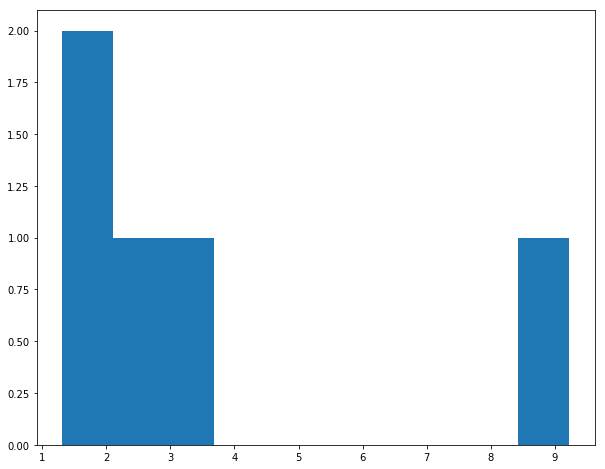

In [60]:
# Let's score the predictions of the model
# model_pred = poisson1.predict(X)
# print(model_pred)

# 1# Show plots
plt.figure(figsize = (10, 8))
plt.hist(predict1[0])

# Evaluate model by metrics
# MSE
model1_mse = metrics.mean_squared_error(predict1, reduced_train[['const', 'Diameter', 'Height', 'ShuckedWeight', 'WholeWeight']])
print('\nThe model MSE is ' + str(round(model1_mse, 3)))

# MAE
model1_mae = metrics.mean_absolute_error(predict1, reduced_train[['const', 'Diameter', 'Height', 'ShuckedWeight', 'WholeWeight']])
print('The model MAE is ' + str(round(model1_mae, 3)))

This shows the predicted rings for the reduced training set (non-zero rings) based on the Poisson model.

### Part 4 - Create Scored Data File

In [61]:
# Use this to predict for the cleaned test data
testpreds = np.round(result1.predict(reduced_test[['const', 'Diameter', 'Height', 'ShuckedWeight', 'WholeWeight']]), 0)
#print(testpreds.head(20))
pred_out['P_TARGET_RINGS'] = testpreds[: ]

In [62]:
testpreds.describe()

count    699.000000
mean      10.728183
std        1.864444
min        7.000000
25%        9.500000
50%       10.000000
75%       11.000000
max       24.000000
dtype: float64

These predictions seem plausible based on training set values.

In [63]:
# Output the predictions file
your_model = pred_out.loc[:,['INDEX','P_TARGET_RINGS']]
print(your_model.head())
your_model.to_csv('Andrew_Knight_Abalone_ScoredTestData.csv', index = False)

   INDEX  P_TARGET_RINGS
0    1.0             9.0
1    3.0            11.0
2   16.0            10.0
3   18.0             9.0
5   24.0            10.0


The predictions output file is named **Andrew_Knight_Abalone_ScoredTestData.csv** and contains the final model predicitons for the test set. 

This file includes the INDEX and the P_TARGET_RINGS, which gives predicted number of rings for Abalones in the test set.